In [1]:
# まずはjupyter notebooks特有のおまじないと
# 必要なライブラリを読み込みます。
%matplotlib inline
from fastai.basics import *
from fastai.vision.all import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

[UPDATE]  
Since deeplearning.net stop providing datasets anymore, I host datasets on my website.  
But I'm not sure how long I can keep it.

In [2]:
# データをダウンロードします。
# ! wget http://shabelab.com/datasets/mnist.pkl.tar.gz

In [ ]:
# データを解凍します。
# ! tar xvzf mnist.pkl.tar.gz

In [ ]:
# データを解凍して、4つの変数に格納します。
# データはnumpy形式になっています。
with open('mnist.pkl', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [3]:
# Pathを設定します。
path = Path("~/.fastai/data/mnist/")

(50000, 784)

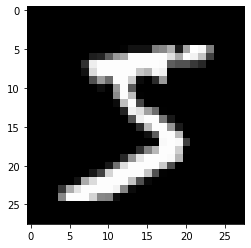

In [5]:
# 一つ表示してみます。
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [11]:
# インプットとアウトプットのカタチを確認しておきます。
x_train, x_train.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 (50000, 784))

In [6]:
y_train, y_train.shape

(array([5, 0, 4, ..., 8, 4, 8]), (50000,))

In [7]:
# numpyからPyTorchのtensorへ変換

x_train,y_train,x_valid,y_valid = map(
    torch.tensor, 
    (x_train,y_train,x_valid,y_valid))

n,c = x_train.shape

x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [13]:
# # ロス関数を定義しておきます。
# # おなじみの差を2乗して平均をとる奴です。

# def mse(y_hat, y):
#     return ((y_hat-y)**2).mean()


In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [14]:
x_train.shape

torch.Size([50000, 784])

In [15]:
y_train.shape

torch.Size([50000])

In [8]:
# PyTorchのDataset、及びTensorDatasetクラスを準備しておきます。
from torch.utils.data import Dataset, TensorDataset

In [9]:
# インプットとアウトプットをぶっ込んでDatasetを作ってくれるのがTensorDatasetです。
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)


In [11]:
# バッチサイズは64にしておきます。
bs=64

In [12]:
# 64個ずつデータをもってこれる用DataLoaderを作成します。

train_dl = DataLoader(train_ds, batch_size=bs)
valid_dl = DataLoader(valid_ds, batch_size=bs)


In [21]:
# DataLoaders was called DataBunch in ver 1.x
# fastai的にはまとめたいので、まとめます。
dls = DataLoaders(train_dl, valid_dl)

In [23]:
# ちゃんとできているか、最初のバッチを取得してみます。
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [25]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb):
        return self.lin(xb)

In [26]:
model = Mnist_Logistic().cuda()

In [27]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [28]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [29]:
x.shape

torch.Size([64, 784])

In [33]:
y, y.shape

(tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
         1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
         9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0]),
 torch.Size([64]))

In [34]:

for p in model.parameters():
    print(p.shape)

torch.Size([10, 784])
torch.Size([10])


In [35]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [36]:
lr=2e-2

In [37]:
loss_func = nn.CrossEntropyLoss()

In [38]:
device = torch.device("cuda")

In [39]:
def update(x,y,lr):
    
    wd = 1e-5
    
    x = x.to(device)
    y = y.to(device)
    
    y_hat = model(x)
    
    # weight decay
    w2 = 0.
    for p in model.parameters():
        w2 += (p**2).sum()
    
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    
    loss.backward()
    
    with torch.no_grad():
        
        for p in model.parameters():
            
            # p = p - lr * p.grad
            p.sub_(lr * p.grad)
            
            p.grad.zero_()
    
    return loss.item()

In [46]:
losses = [update(x,y,lr) for x,y in dls.train]

# losses = []
# for x, y in data.train_dl:
#     loss = update(x, y, lr)
#     losses.append(loss)

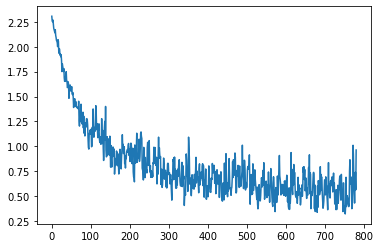

In [47]:
plt.plot(losses);

In [48]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 105, bias=True)
        self.lin2 = nn.Linear(105, 50, bias=True)
        self.lin3 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        
        x = self.lin1(xb)
        x = F.relu(x)
        
        x = self.lin2(x)
        x = F.relu(x)
        
        x = self.lin3(x)
        
        return x

In [49]:
model = Mnist_NN().cuda()

In [50]:
model

Mnist_NN(
  (lin1): Linear(in_features=784, out_features=105, bias=True)
  (lin2): Linear(in_features=105, out_features=50, bias=True)
  (lin3): Linear(in_features=50, out_features=10, bias=True)
)

In [51]:
losses = [update(x,y,lr) for x,y in dls.train]

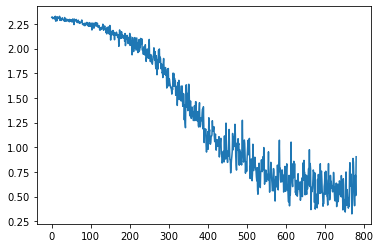

In [52]:
plt.plot(losses);

In [53]:
# lr=
model = Mnist_NN().cuda()

In [54]:
def update(x,y,lr):
    
    x = x.to(device)
    y = y.to(device)
    
    opt = optim.Adam(model.parameters(), lr)
    
    # opt = optim.SGD(model.parameters(), lr)
    
    y_hat = model(x)
    
    loss = loss_func(y_hat, y)
    
    loss.backward()
    
    
    opt.step()
    
    opt.zero_grad()
    
    
    
    return loss.item()

In [ ]:
# losses = [update(x,y,2e-2) for x,y in data.train_dl]

In [56]:
from torch import optim

In [57]:
# sgd
# losses = [update(x,y,1e-4) for x,y in dls.train]

# adam
losses = [update(x,y,1e-4) for x,y in dls.train]

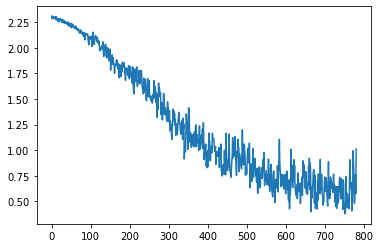

In [58]:
plt.plot(losses);

In [59]:
# fastai 的にやる

learn = Learner(dls, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.007585775572806597)

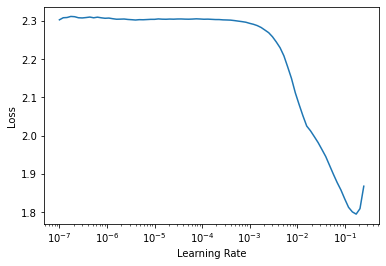

In [61]:
learn.lr_find()


In [62]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.161573,0.116562,0.965000,00:02


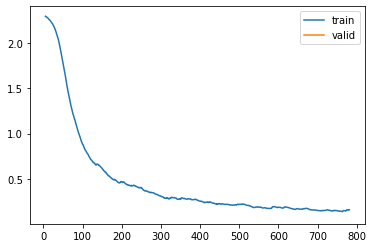

In [64]:
learn.recorder.plot_loss()

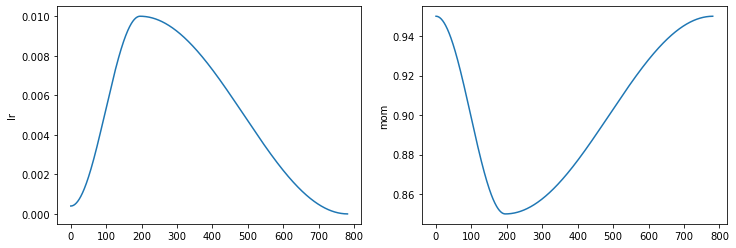

In [66]:
learn.recorder.plot_sched()

## fin